In [ ]:
import numpy as np
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt


In [ ]:
test=pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
train=pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
ntrain = train.shape[0]
ntest = test.shape[0]
df = pd.concat((train, test)).reset_index(drop=True)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [ ]:
temp = (df.isnull().sum() / len(df)) * 100
temp = temp.drop(temp[temp == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :temp})
missing_data

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
SalePrice,49.982871
FireplaceQu,48.646797
LotFrontage,16.649538
GarageYrBlt,5.447071
GarageFinish,5.447071
GarageQual,5.447071


## Missing Data

In [ ]:
df.drop(['Id','PoolQC','MiscFeature','Alley','FireplaceQu','Utilities'], axis=1, inplace=True)

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','Fence','MSSubClass',
           'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','MasVnrType'):
    df[col] = df[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 
            'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath','MasVnrArea'):
    df[col] = df[col].fillna(0)
    
for col in ('Electrical','MSZoning','KitchenQual','Exterior1st','Exterior2nd','SaleType'):
    df[col] = df[col].fillna(df[col].mode()[0])

for col in ('YrSold', 'MoSold','OverallCond'):
    df[col] = df[col].astype(str)
    
df["Functional"] = df["Functional"].fillna("Typ")

df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [ ]:
temp = (df.isnull().sum() / len(df)) * 100
temp = temp.drop(temp[temp == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :temp})
missing_data

,Missing Ratio
SalePrice,49.982871


### TotalSF is new feature that is the total squarefoot of the home. I am using this because generally, the more liveable space you have, the higher the cost. 

In [ ]:
df['TotalSF'] = df['TotalBsmtSF'] + df['GrLivArea']
df.drop(['TotalBsmtSF','GrLivArea'], axis=1, inplace=True)

### TotalSF_Log is the log of TotalSF. I did this because it was highly skewed.

Skewness: 1.511934


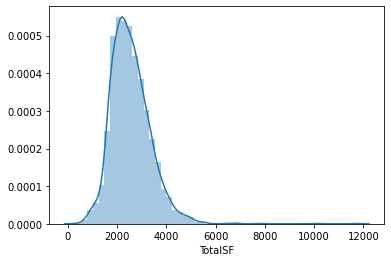

In [ ]:
sns.distplot(df['TotalSF']);
print("Skewness: %f" % df['TotalSF'].skew())

Skewness: -0.360364


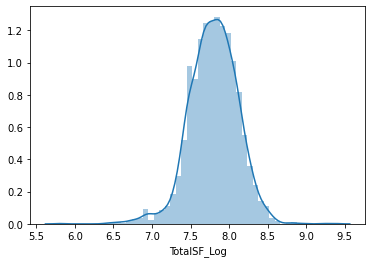

In [ ]:
df['TotalSF_Log'] = np.log(df['TotalSF'])
sns.distplot(df['TotalSF_Log']);
print("Skewness: %f" % df['TotalSF_Log'].skew())
df.drop(['TotalSF'], axis=1, inplace=True)

### SoldAge is a new feature that is the age of the building. I chose this because the higher this number, the less valuable the building is. 

In [ ]:
df["SoldAge"] = df["YrSold"].astype(int) - df["YearBuilt"] 
df.drop(['YrSold'], axis=1, inplace=True)

### TotalBath is a new feature that has the total number of bathrooms in the building. The more bathrooms you have, the more liveable space you have, which means cost is higher.

In [ ]:
df['TotalBath']=0.5*df['HalfBath'] + df['FullBath'] + 0.5*df['BsmtHalfBath'] + df['BsmtFullBath']
df.drop(['HalfBath','FullBath','BsmtHalfBath','BsmtFullBath'], axis=1, inplace=True)

### Remodeled is a new feature that states whether a building as been remodeled or not. Generally, if a building gets remodeled, it is because the seller wants to sell the building for higher.

In [ ]:
df['Remodeled']= np.where((df['YearRemodAdd']-df['YearBuilt']) != 0,1,0) 
df.drop(['YearRemodAdd','YearBuilt'], axis=1, inplace=True)

### SalePrice_Log is the log of SalePrice. I did this because it was highly skewed.

Skewness: 1.882876


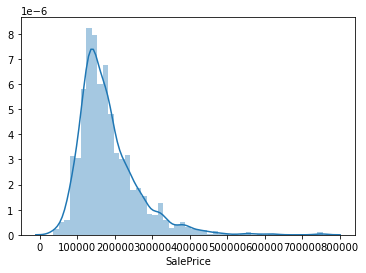

In [ ]:
sns.distplot(df['SalePrice']);
print("Skewness: %f" % df['SalePrice'].skew())

Skewness: 0.121335


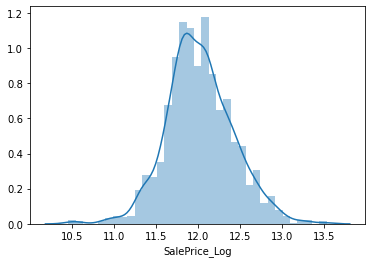

In [ ]:
df['SalePrice_Log'] = np.log(df['SalePrice'])
sns.distplot(df['SalePrice_Log']);
print("Skewness: %f" % df['SalePrice_Log'].skew())
df.drop(['SalePrice'], axis=1, inplace=True)

### MSSubClass_Log is the log of MSSubClass. I did this because it was highly skewed.

Skewness: 1.376165


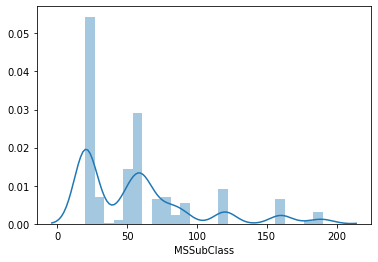

In [ ]:
sns.distplot(df['MSSubClass']);
print("Skewness: %f" % df['MSSubClass'].skew())

Skewness: 0.229245


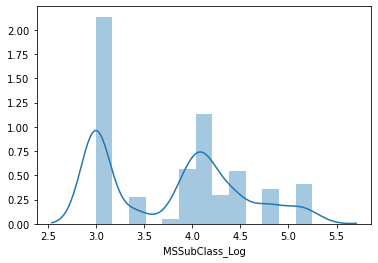

In [ ]:
df['MSSubClass_Log'] = np.log(df['MSSubClass'])
sns.distplot(df['MSSubClass_Log']);
print("Skewness: %f" % df['MSSubClass_Log'].skew())
df.drop(['MSSubClass'], axis=1, inplace=True)

## Model

### I used this chart: 
![image.png](attachment:image.png)


### and this notebook: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
### to choose the 10 features

I really do not remember nor can I find where this chart came from. All I know it was from a Kaggle submission.

## Features Chosen
### From dataset
'OverallQual'
'GarageCars'
'Neighborhood'
'ExterQual'
'KitchenQual'

### Created
'TotalSF_Log'
'TotalBath'
'SoldAge'
'MSSubClass_Log'
'Remodeled'

I chose to include those five features from the dataset because the chart above and multiple Kaggle notebooks conclude that those five are highly correlated to the sale price.

In [ ]:
col=['OverallQual',
'GarageCars',
'Neighborhood',
'ExterQual',
'KitchenQual',
'TotalSF_Log',
'TotalBath',
'SoldAge',
'MSSubClass_Log',
'Remodeled',
'SalePrice_Log']
labelencoder = LabelEncoder()
train = df[:ntrain]
test = df[ntrain:]
train=train[col]
test=test[col]
for i in ['Neighborhood','ExterQual','KitchenQual']:
    train[i]=labelencoder.fit_transform(train[i])
    test[i]=labelencoder.fit_transform(test[i])
test.drop('SalePrice_Log',1,inplace=True)
train.head()

,OverallQual,GarageCars,Neighborhood,ExterQual,KitchenQual,TotalSF_Log,TotalBath,SoldAge,MSSubClass_Log,Remodeled,SalePrice_Log
0,7,2.0,5,2,2,7.850104,3.5,5,4.094345,0,12.247694
1,6,2.0,24,3,3,7.833600,2.5,31,2.995732,0,12.109011
2,7,2.0,5,2,2,7.903227,3.5,7,4.094345,1,12.317167
3,7,3.0,6,3,2,7.813187,2.0,91,4.248495,1,11.849398
4,8,3.0,15,2,2,8.114624,3.5,8,4.094345,0,12.429216


## SVR

In [ ]:
y = np.array(train['SalePrice_Log'])
X= np.array(train.drop(['SalePrice_Log'],1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
svrs = [SVR(kernel='linear', gamma='scale'), SVR(kernel='poly', gamma='scale'), SVR(kernel='rbf', gamma='scale'),
       SVR(kernel='sigmoid', gamma='scale')]
for model in svrs:
    model.fit(X_train,y_train)
    print(model.score(X_test, y_test))

0.8001782971514625
0.5798434090274847
0.7993711256674261
-6743.535308947552


In [ ]:
svrs = [SVR(kernel='linear', gamma='auto'), SVR(kernel='rbf', gamma='auto')]
for model in svrs:
    model.fit(X_train,y_train)
    print(model.score(X_test, y_test))

0.8001782971514625
0.7659353747755555


In [ ]:
model=SVR(kernel='linear', gamma='scale',epsilon=0.1)
model.fit(X_train,y_train)
print(model.score(X_test, y_test))

0.8001782971514625


In [ ]:
model=SVR(kernel='linear', gamma='scale',epsilon=0.00001)
model.fit(X_train,y_train)
print(model.score(X_test, y_test))

0.8069342837812593


In [ ]:
model=SVR(kernel='linear', gamma='scale',epsilon=0.0000000000000001)
model.fit(X_train,y_train)
print(model.score(X_test, y_test))

0.807044833887308


## Linear Reg, Decision Tree Reg, SVR

In [ ]:
def modelsR(X_train, X_test, y_train, y_test):
    print('LinearRegression')
    regressor = LinearRegression()  
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('R-squared Error:', metrics.r2_score(y_test, y_pred))
    plt.figure(0)
    plt.scatter(y_test,y_pred)
    plt.xlabel('Real', fontsize=12)
    plt.ylabel('Pred', fontsize=12)
    
    
    print('\nDecisionTreeRegressor')
    regressor = DecisionTreeRegressor()
    regressor.fit(X_train,y_train)
    y_pred = regressor.predict(X_test)
    print('R-squared Error: ',regressor.score(X_test, y_test))
    plt.figure(1)
    plt.scatter(y_test,y_pred)
    plt.xlabel('Real', fontsize=12)
    plt.ylabel('Pred', fontsize=12)
    
    print('\nSVM')
    model=SVR(kernel='linear', gamma='scale',epsilon=0.0000000000000001)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(model.score(X_test, y_test))
    plt.figure(2)
    plt.scatter(y_test,y_pred)
    plt.xlabel('Real', fontsize=12)
    plt.ylabel('Pred', fontsize=12)

In [ ]:
modelsR(X_train, X_test, y_train, y_test)

LinearRegression
Mean Absolute Error: 0.11842028092980085
Mean Squared Error: 0.030482129642932874
Root Mean Squared Error: 0.1745913217858576
R-squared Error: 0.798664719439327
DecisionTreeRegressor
R-squared Error:  0.7553049306747567
SVM
0.807044833887308


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)
modelsR(X_train, X_test, y_train, y_test)

LinearRegression
Mean Absolute Error: 0.11270778989259678
Mean Squared Error: 0.026802381189955864
Root Mean Squared Error: 0.16371432799225566
R-squared Error: 0.8265343063477129
DecisionTreeRegressor
R-squared Error:  0.7445285519244591
SVM
0.8326315374028255


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)
modelsR(X_train, X_test, y_train, y_test)

LinearRegression
Mean Absolute Error: 0.11529043899116466
Mean Squared Error: 0.02478783048698355
Root Mean Squared Error: 0.1574415144966014
R-squared Error: 0.8538851114737037
DecisionTreeRegressor
R-squared Error:  0.784851493464386
SVM
0.855191747173396


LinearRegression
Mean Absolute Error: 0.11529043899116466
Mean Squared Error: 0.02478783048698355
Root Mean Squared Error: 0.1574415144966014
R-squared Error: 0.8538851114737037
DecisionTreeRegressor
R-squared Error:  0.7650473618320013
SVM
0.855191747173396


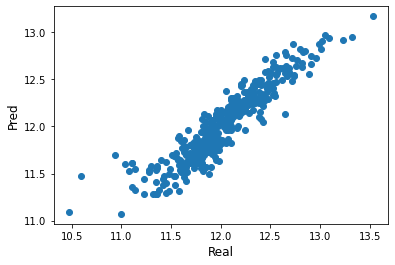

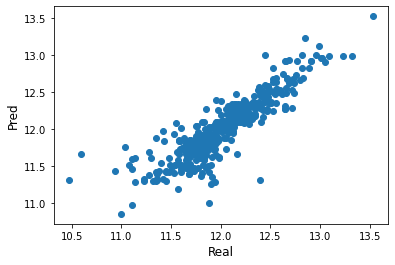

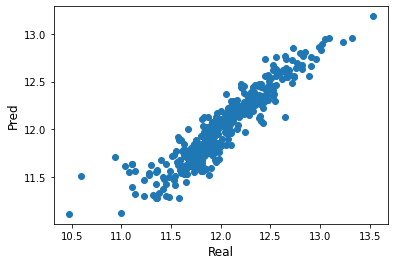

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)
modelsR(X_train, X_test, y_train, y_test)

The higest r^2 value came from the SVR at 85.52%. followed by the linear regression at 85.39% and the decision tree at 76.23%. It is quite clear the winning algorithm is the SVR, but with a 10 feature limit, it is hard to push the score higher. 

Also, the scatter plots above show there are outliers in the data. I believe if I were to take out the outliers, the score of these models would be higher. The plots also show how close the linear regression line and SVR are. 

Overall, I believe the features I chose were correct. The only improvments I would make would be to remove all outliers and include more features.